# Fitting and assessing the performance of multiple CLASSIFICATION models

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster import hierarchy
import statsmodels.formula.api as smf\

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [137]:
sns.set_palette("colorblind")

In [138]:
songs_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'

df = pd.read_csv(songs_url)

In [139]:
df.shape

(32833, 23)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [141]:
df.nunique()

track_id                    28356
track_name                  23449
track_artist                10692
track_popularity              101
track_album_id              22545
track_album_name            19743
track_album_release_date     4530
playlist_name                 449
playlist_id                   471
playlist_genre                  6
playlist_subgenre              24
danceability                  822
energy                        952
key                            12
loudness                    10222
mode                            2
speechiness                  1270
acousticness                 3731
instrumentalness             4729
liveness                     1624
valence                      1362
tempo                       17684
duration_ms                 19785
dtype: int64

In [142]:
df.dtypes

track_id                     object
track_name                   object
track_artist                 object
track_popularity              int64
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
dtype: object

In [144]:
# Create a target variable - track_populairy_bin (y)

df['track_popularity_bin'] = np.where( df.track_popularity > 50, 1, 0 )
df = df.astype({'track_popularity_bin': 'object'})
df.track_popularity_bin.value_counts(normalize=True)

track_popularity_bin
0    0.574757
1    0.425243
Name: proportion, dtype: float64

## Modeling - Pre-modeling activities

#### Data Cleanup

In [145]:
#  Removing duplicates - More details in the EDA notebook

df.drop_duplicates(subset=['track_id'], keep='first', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28356 entries, 0 to 32832
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  28356 non-null  object 
 1   track_name                28352 non-null  object 
 2   track_artist              28352 non-null  object 
 3   track_popularity          28356 non-null  int64  
 4   track_album_id            28356 non-null  object 
 5   track_album_name          28352 non-null  object 
 6   track_album_release_date  28356 non-null  object 
 7   playlist_name             28356 non-null  object 
 8   playlist_id               28356 non-null  object 
 9   playlist_genre            28356 non-null  object 
 10  playlist_subgenre         28356 non-null  object 
 11  danceability              28356 non-null  float64
 12  energy                    28356 non-null  float64
 13  key                       28356 non-null  int64  
 14  loudness   

In [146]:
# Remove identifier columns

df.drop(['track_id','track_album_id','playlist_id','track_artist','playlist_name', 'track_name', 'track_album_name'],
        inplace=True,
        axis=1)

In [147]:
# Remove `playlist_subgenre` as it is high correlated with `playlist_genre`

df.drop(columns=['playlist_subgenre'], inplace=True)

In [148]:
# Drop `track_album_release_date` 

df.drop(columns=['track_album_release_date'], inplace=True)

#### Addressing Skewness

In [149]:
df_features = df.select_dtypes('number').copy()
df_features.drop(['track_popularity'], axis=1, inplace=True)

In [150]:
df_objects = df.select_dtypes('object').copy()

In [151]:
id_cols = ['rowid', 'track_popularity'] + df_objects.columns.to_list()

In [152]:
df_lf = df.reset_index().\
rename(columns={'index': 'rowid'}).\
melt(id_vars=id_cols, value_vars=df_features.columns)

In [153]:
df_lf

,rowid,track_popularity,playlist_genre,track_popularity_bin,variable,value
0,0,66,pop,1,danceability,0.748
1,1,67,pop,1,danceability,0.726
2,2,70,pop,1,danceability,0.675
3,3,60,pop,1,danceability,0.718
4,4,69,pop,1,danceability,0.650
...,...,...,...,...,...,...
340267,32828,42,edm,0,duration_ms,204375.000
340268,32829,20,edm,0,duration_ms,353120.000
340269,32830,14,edm,0,duration_ms,210112.000
340270,32831,15,edm,0,duration_ms,367432.000


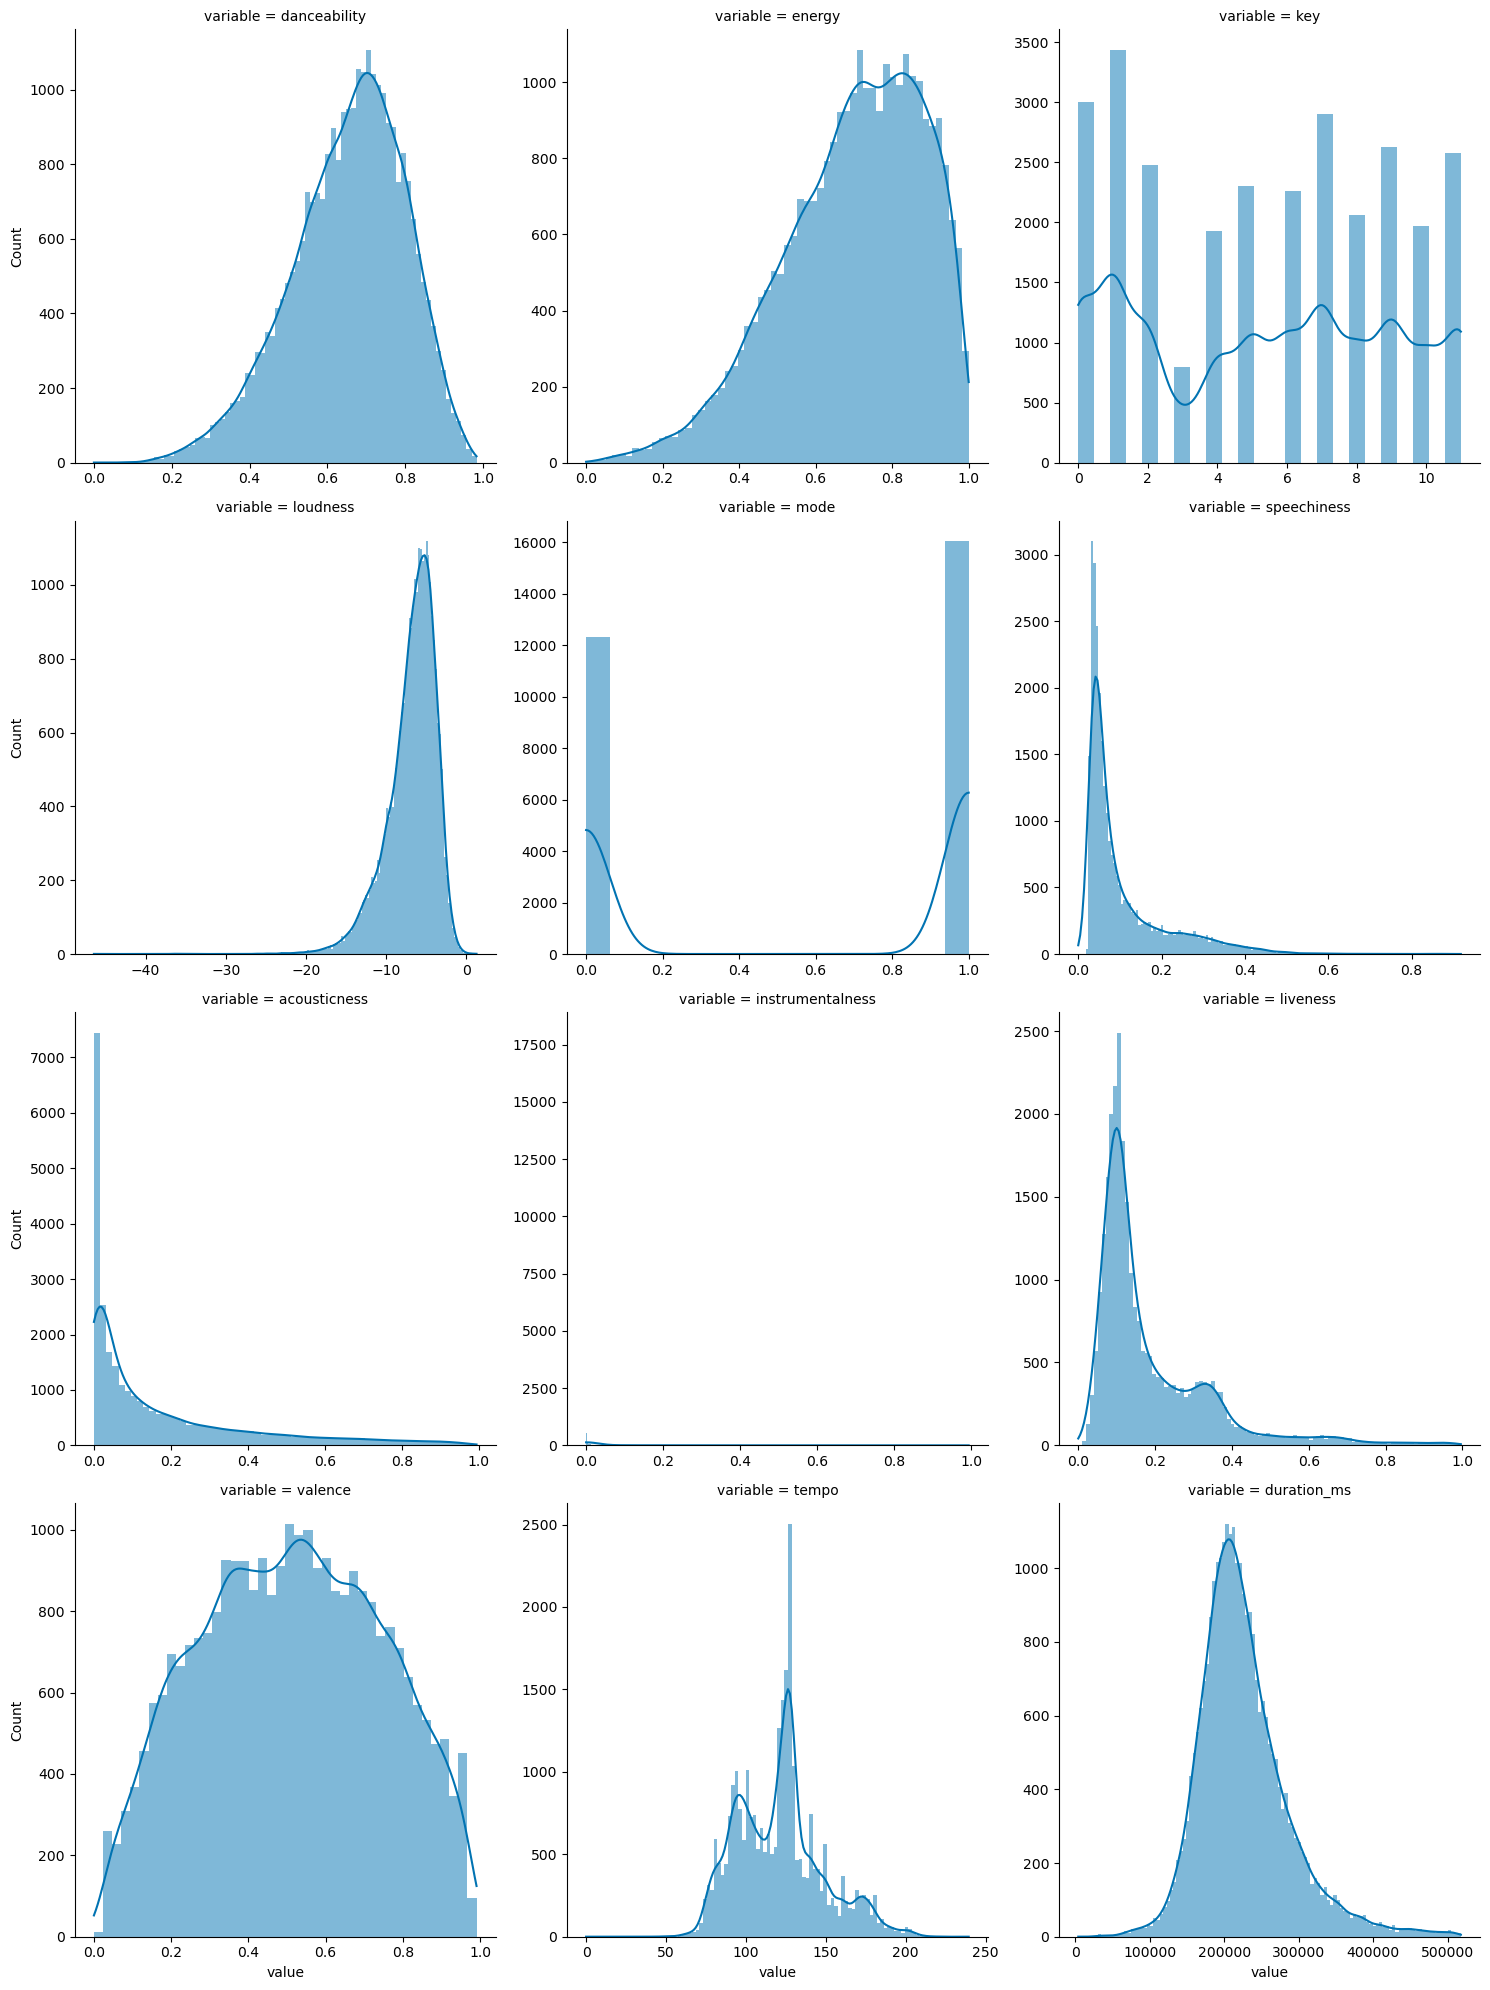

In [154]:
sns.displot(data = df_lf, x='value', col='variable', kind='hist', kde=True,
            facet_kws={'sharex': False, 'sharey': False},
            common_bins=False,
            col_wrap=3)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout()
plt.tight_layout()
plt.show()

In [155]:
# Reducing skewness by applying log transform

df['speechiness_log'] = df['speechiness'].apply(lambda x: np.log(x) if x > 0 else 0)
df['acousticness_log'] = df['acousticness'].apply(lambda x: np.log(x) if x > 0 else 0)
df['instrumentalness_log'] = df['instrumentalness'].apply(lambda x: np.log(x) if x > 0 else 0)
df['liveness_log'] = df['liveness'].apply(lambda x: np.log(x) if x > 0 else 0)
df['duration_ms_log'] = df['duration_ms'].apply(lambda x: np.log(x) if x > 0 else 0)

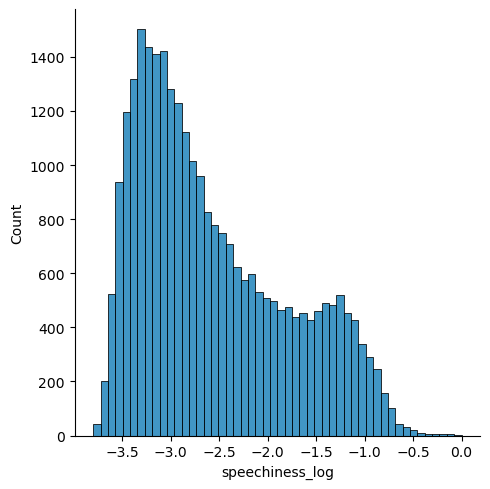

In [156]:
sns.displot(data = df, x='speechiness_log', kind='hist')

plt.show()

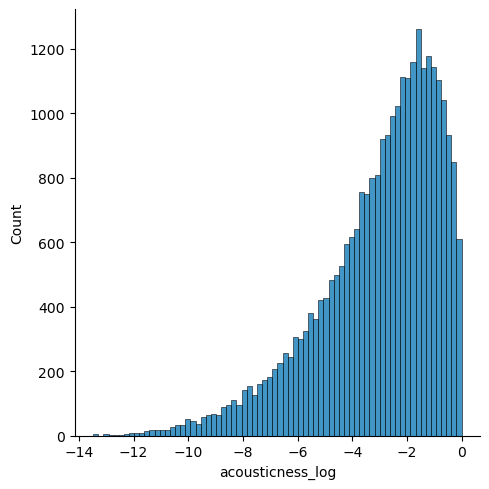

In [157]:
sns.displot(data = df, x='acousticness_log', kind='hist')

plt.show()

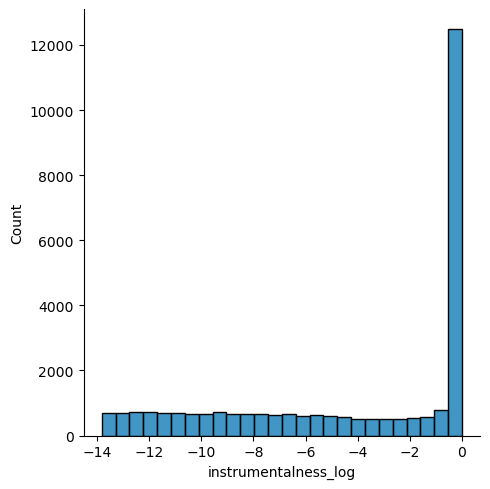

In [158]:
sns.displot(data = df, x='instrumentalness_log', kind='hist')

plt.show()

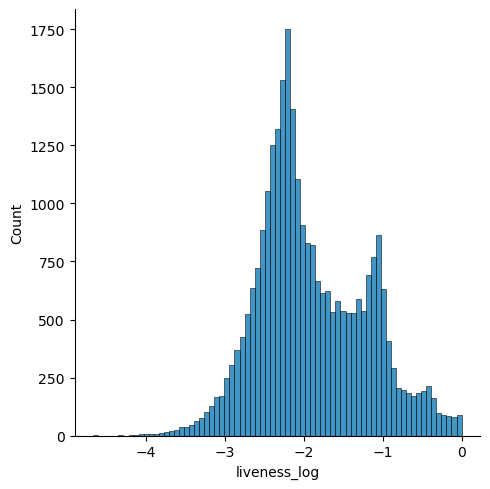

In [159]:
sns.displot(data = df, x='liveness_log', kind='hist')

plt.show()

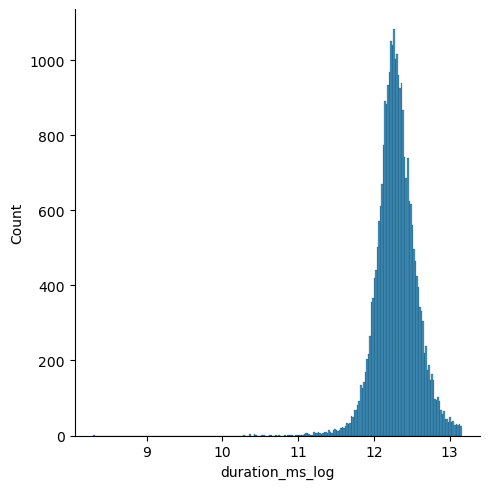

In [160]:
sns.displot(data = df, x='duration_ms_log', kind='hist')

plt.show()

## Modeling - Fitting models

##### Define a function to FIT and CALCULATE the training set performance

In [161]:
def fit_and_assess_logistic(mod_name, a_formula, train_data, threshold):
    a_mod = smf.logit(formula=a_formula, data=train_data).fit()

    train_copy = train_data.copy()

    train_copy['pred_probability'] = a_mod.predict(train_data)

    train_copy['pred_class'] = np.where(train_copy.pred_probability > threshold, 1, 0 )

    TN, FP, FN, TP = confusion_matrix(train_copy.y.to_numpy(), train_copy.pred_class.to_numpy() ).ravel()

    Accuracy = (TN + TP) / (TN + FP + FN + TP)

    Sensitivity = (TP) / (TP + FN)

    Specificity = (TN) / (TN + FP)

    FPR = 1 - Specificity

    ROC_AUC = roc_auc_score(train_copy.y.to_numpy(), train_copy.pred_probability.to_numpy() )

    res_dict = {'model_name': mod_name,
                'model_formula': a_formula,
                'num_coefs': len( a_mod.params ),
                'threshold': threshold,
                'Accuracy': Accuracy,
                'Sensitivity': Sensitivity,
                'Specificity': Specificity,
                'FPR': FPR,
                'ROC_AUC': ROC_AUC}

    return pd.DataFrame( res_dict, index=[0] )

In [166]:
df['y'] = df['track_popularity_bin']
df = df.astype({'y': 'int'})

y
0    0.629496
1    0.370504
Name: proportion, dtype: float64

In [167]:
fit_and_assess_logistic(0, 'y ~ 1', train_data=df, threshold=0.5)

Optimization terminated successfully.
         Current function value: 0.659223
         Iterations 4


,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,0,y ~ 1,1,0.5,0.629496,0.0,1.0,0.0,0.5


In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28356 entries, 0 to 32832
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   track_popularity      28356 non-null  int64  
 1   playlist_genre        28356 non-null  object 
 2   danceability          28356 non-null  float64
 3   energy                28356 non-null  float64
 4   key                   28356 non-null  int64  
 5   loudness              28356 non-null  float64
 6   mode                  28356 non-null  int64  
 7   speechiness           28356 non-null  float64
 8   acousticness          28356 non-null  float64
 9   instrumentalness      28356 non-null  float64
 10  liveness              28356 non-null  float64
 11  valence               28356 non-null  float64
 12  tempo                 28356 non-null  float64
 13  duration_ms           28356 non-null  int64  
 14  track_popularity_bin  28356 non-null  object 
 15  speechiness_log       28

In [280]:
formula_list = ['y ~ 1',
                'y ~ playlist_genre + key + mode',
                'y ~ tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log',
                'y ~ playlist_genre + key + mode + tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log',
                'y ~ (tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log) ** 2',
                'y ~ mode * (tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log)',
                'y ~ playlist_genre * (tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log)',
                'y ~ playlist_genre * ( (tempo + loudness + valence + danceability + energy + duration_ms_log + speechiness_log + instrumentalness_log + liveness_log + acousticness_log)**2 \
                + np.power(tempo,2) + np.power(loudness,2) + np.power(valence,2) + np.power(danceability,2) + np.power(energy,2) + np.power(duration_ms_log,2) + np.power(speechiness_log,2) + \
                np.power(instrumentalness_log,2) + np.power(liveness_log,2) + np.power(acousticness_log,2))',
                'y ~ playlist_genre * ( (tempo + loudness + valence + danceability + energy + duration_ms + speechiness + instrumentalness + liveness + acousticness)**2 \
                + np.power(tempo,2) + np.power(loudness,2) + np.power(valence,2) + np.power(danceability,2) + np.power(energy,2) + np.power(duration_ms,2) + np.power(speechiness,2) + \
                np.power(instrumentalness,2) + np.power(liveness,2) + np.power(acousticness,2) + np.power(tempo,3) + np.power(loudness,3) + np.power(valence,3) + \
                np.power(danceability,3) + np.power(energy,3) + np.power(duration_ms,3) + np.power(speechiness,3) + np.power(instrumentalness,3) + \
                np.power(liveness,3) + np.power(acousticness,3))'
               ]


In [281]:
results_list = []

for x in range(len(formula_list)):
    results_list.append(
        fit_and_assess_logistic(x, formula_list[x], train_data = df, threshold=0.5) )

Optimization terminated successfully.
         Current function value: 0.659223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597308
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.593966
         Iterations 10


In [282]:
results_df = pd.concat(results_list, ignore_index=True)
results_df

,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
0,0,y ~ 1,1,0.5,0.629496,0.000000,1.000000,0.000000,0.500000
1,1,y ~ playlist_genre + key + mode,8,0.5,0.629496,0.000000,1.000000,0.000000,0.614164
2,2,y ~ tempo + loudness + valence + danceability ...,11,0.5,0.631471,0.094993,0.947227,0.052773,0.611263
3,3,y ~ playlist_genre + key + mode + tempo + loud...,18,0.5,0.645013,0.246907,0.879328,0.120672,0.661755
4,4,y ~ (tempo + loudness + valence + danceability...,56,0.5,0.638489,0.138778,0.932605,0.067395,0.629157
5,5,y ~ mode * (tempo + loudness + valence + dance...,22,0.5,0.632741,0.103560,0.944202,0.055798,0.613896
6,6,y ~ playlist_genre * (tempo + loudness + valen...,66,0.5,0.657215,0.283267,0.877311,0.122689,0.677108
7,7,y ~ playlist_genre * ( (tempo + loudness + val...,396,0.5,0.669453,0.360937,0.851036,0.148964,0.701659
8,8,y ~ playlist_genre * ( (tempo + loudness + val...,456,0.5,0.672415,0.373596,0.848291,0.151709,0.706141


In [283]:
results_df.sort_values(by=['Accuracy'], ascending=False)

,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
8,8,y ~ playlist_genre * ( (tempo + loudness + val...,456,0.5,0.672415,0.373596,0.848291,0.151709,0.706141
7,7,y ~ playlist_genre * ( (tempo + loudness + val...,396,0.5,0.669453,0.360937,0.851036,0.148964,0.701659
6,6,y ~ playlist_genre * (tempo + loudness + valen...,66,0.5,0.657215,0.283267,0.877311,0.122689,0.677108
3,3,y ~ playlist_genre + key + mode + tempo + loud...,18,0.5,0.645013,0.246907,0.879328,0.120672,0.661755
4,4,y ~ (tempo + loudness + valence + danceability...,56,0.5,0.638489,0.138778,0.932605,0.067395,0.629157
5,5,y ~ mode * (tempo + loudness + valence + dance...,22,0.5,0.632741,0.103560,0.944202,0.055798,0.613896
2,2,y ~ tempo + loudness + valence + danceability ...,11,0.5,0.631471,0.094993,0.947227,0.052773,0.611263
0,0,y ~ 1,1,0.5,0.629496,0.000000,1.000000,0.000000,0.500000
1,1,y ~ playlist_genre + key + mode,8,0.5,0.629496,0.000000,1.000000,0.000000,0.614164


In [284]:
results_df.sort_values(by=['ROC_AUC'], ascending=False)

,model_name,model_formula,num_coefs,threshold,Accuracy,Sensitivity,Specificity,FPR,ROC_AUC
8,8,y ~ playlist_genre * ( (tempo + loudness + val...,456,0.5,0.672415,0.373596,0.848291,0.151709,0.706141
7,7,y ~ playlist_genre * ( (tempo + loudness + val...,396,0.5,0.669453,0.360937,0.851036,0.148964,0.701659
6,6,y ~ playlist_genre * (tempo + loudness + valen...,66,0.5,0.657215,0.283267,0.877311,0.122689,0.677108
3,3,y ~ playlist_genre + key + mode + tempo + loud...,18,0.5,0.645013,0.246907,0.879328,0.120672,0.661755
4,4,y ~ (tempo + loudness + valence + danceability...,56,0.5,0.638489,0.138778,0.932605,0.067395,0.629157
1,1,y ~ playlist_genre + key + mode,8,0.5,0.629496,0.000000,1.000000,0.000000,0.614164
5,5,y ~ mode * (tempo + loudness + valence + dance...,22,0.5,0.632741,0.103560,0.944202,0.055798,0.613896
2,2,y ~ tempo + loudness + valence + danceability ...,11,0.5,0.631471,0.094993,0.947227,0.052773,0.611263
0,0,y ~ 1,1,0.5,0.629496,0.000000,1.000000,0.000000,0.500000


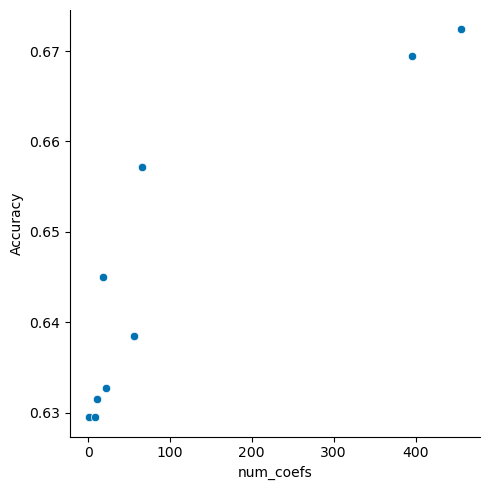

In [285]:
sns.relplot(data = results_df, x='num_coefs', y='Accuracy', kind='scatter')

plt.show()

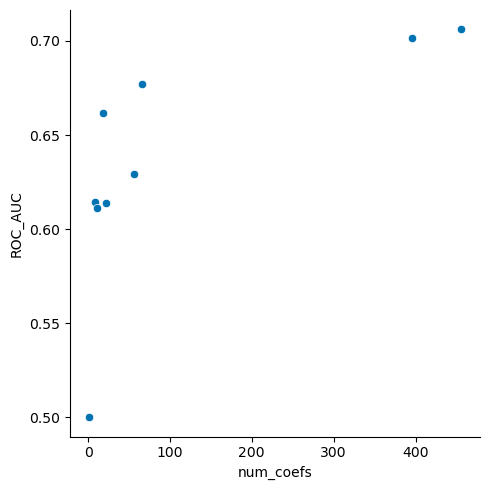

In [286]:
sns.relplot(data = results_df, x='num_coefs', y='ROC_AUC', kind='scatter')

plt.show()

In [297]:
def fit_logistic_make_roc(mod_name, a_formula, train_data):
    a_mod = smf.logit(formula=a_formula, data=train_data).fit()
    
    train_copy = train_data.copy()
    
    train_copy['pred_probability'] = a_mod.predict( train_data )
    
    fpr, tpr, threshold = roc_curve( train_data.y.to_numpy(), train_copy.pred_probability.to_numpy() )
    
    res_df = pd.DataFrame({'tpr': tpr,
                           'fpr': fpr,
                           'threshold': threshold})
    
    res_df['model_name'] = mod_name
    res_df['model_formula'] = a_formula
    
    return res_df

In [298]:
roc_list = []

for m in range( len(formula_list) ):
    roc_list.append( fit_logistic_make_roc( m, formula_list[m], train_data=df))

Optimization terminated successfully.
         Current function value: 0.659223
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.635441
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.642106
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.620351
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.633988
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.641314
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.612935
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597308
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.593966
         Iterations 10


In [299]:
roc_df = pd.concat( roc_list, ignore_index=True )
roc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87666 entries, 0 to 87665
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tpr            87666 non-null  float64
 1   fpr            87666 non-null  float64
 2   threshold      87666 non-null  float64
 3   model_name     87666 non-null  int64  
 4   model_formula  87666 non-null  object 
dtypes: float64(3), int64(1), object(1)
memory usage: 3.3+ MB


In [300]:
roc_df['model_name'] = roc_df.model_name.astype('category')
roc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87666 entries, 0 to 87665
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   tpr            87666 non-null  float64 
 1   fpr            87666 non-null  float64 
 2   threshold      87666 non-null  float64 
 3   model_name     87666 non-null  category
 4   model_formula  87666 non-null  object  
dtypes: category(1), float64(3), object(1)
memory usage: 2.8+ MB


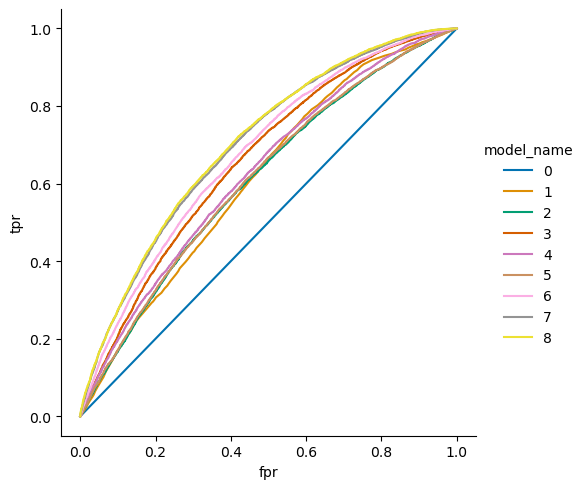

In [302]:
sns.relplot(data = roc_df, x='fpr', y='tpr', hue='model_name',
            kind='line', estimator=None, units='model_name')

plt.show()

In [294]:
roc_df

,tpr,fpr,threshold,model_name,model_formula
0,0.000000,0.000000,inf,0,y ~ 1
1,1.000000,1.000000,0.370504,0,y ~ 1
2,0.000000,0.000000,inf,1,y ~ playlist_genre + key + mode
3,0.019989,0.014006,0.496819,1,y ~ playlist_genre + key + mode
4,0.036931,0.023249,0.496563,1,y ~ playlist_genre + key + mode
...,...,...,...,...,...
87661,0.999810,0.989972,0.021645,8,y ~ playlist_genre * ( (tempo + loudness + val...
87662,0.999905,0.989972,0.021641,8,y ~ playlist_genre * ( (tempo + loudness + val...
87663,0.999905,0.993109,0.016582,8,y ~ playlist_genre * ( (tempo + loudness + val...
87664,1.000000,0.993109,0.016333,8,y ~ playlist_genre * ( (tempo + loudness + val...


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for _, unit_data in sub_data.groupby("units"):
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/relational.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain 

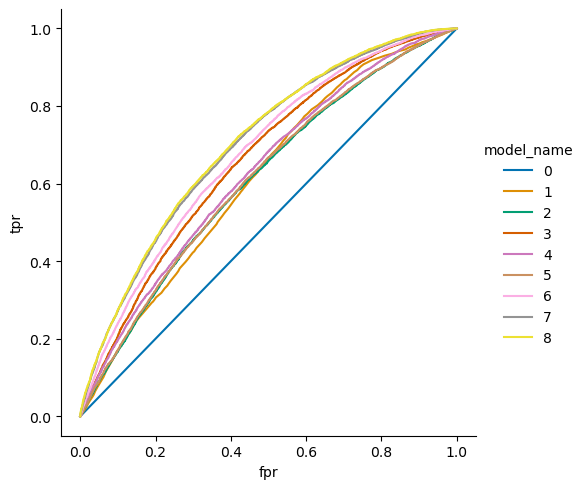

In [296]:
sns.relplot(data = roc_df, x='fpr', y='tpr', hue='model_name',
            kind='line', estimator=None, units='model_name')

plt.show()

In [ ]:
Performance and Validation